<a href="https://colab.research.google.com/github/vin136/uncertainty-estimates/blob/vin-ideas_1/nbs/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoders
Implementation References : [Pytorch-examples](https://github.com/pytorch/examples/blob/master/vae/main.py), [Deep-learning Course](https://sebastianraschka.com/blog/2021/dl-course.html#l17-variational-autoencoders)


In [36]:
# Train a VAE on MNIST
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [37]:
device = 'cuda'
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [38]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [39]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
                #save_image(comparison.cpu(),
                         #'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [40]:
from argparse import Namespace
args = Namespace(
    epochs = 10,
    seed = 0,
    cuda = True,
    batch_size = 128,
    log_interval = 10000
    
   
)



import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np





Train Epoch: 1 [0/60000 (0%)]	Loss: 550.153198
====> Epoch: 1 Average loss: 164.8235
====> Test set loss: 127.4891


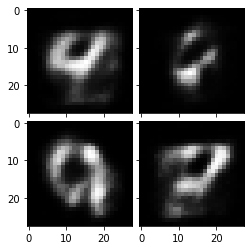

Train Epoch: 2 [0/60000 (0%)]	Loss: 127.430847
====> Epoch: 2 Average loss: 121.2120
====> Test set loss: 115.8314


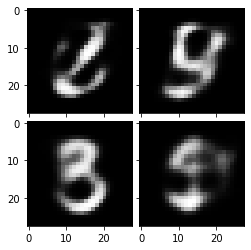

Train Epoch: 3 [0/60000 (0%)]	Loss: 121.514389
====> Epoch: 3 Average loss: 114.4246
====> Test set loss: 111.9068


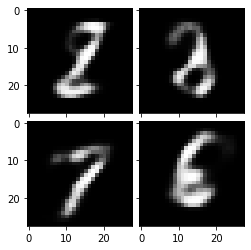

Train Epoch: 4 [0/60000 (0%)]	Loss: 109.403168
====> Epoch: 4 Average loss: 111.5156
====> Test set loss: 110.0864


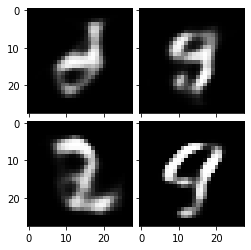

Train Epoch: 5 [0/60000 (0%)]	Loss: 112.434387
====> Epoch: 5 Average loss: 109.8203
====> Test set loss: 108.6833


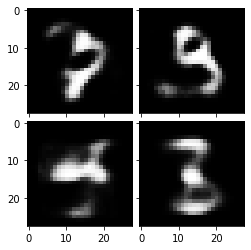

Train Epoch: 6 [0/60000 (0%)]	Loss: 106.353569
====> Epoch: 6 Average loss: 108.6253
====> Test set loss: 107.4762


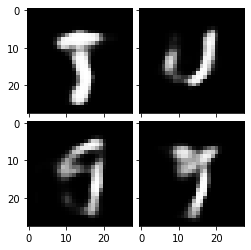

Train Epoch: 7 [0/60000 (0%)]	Loss: 110.501450
====> Epoch: 7 Average loss: 107.7246
====> Test set loss: 106.8298


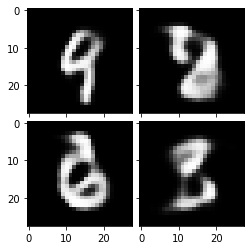

Train Epoch: 8 [0/60000 (0%)]	Loss: 106.657860
====> Epoch: 8 Average loss: 107.0220
====> Test set loss: 106.3602


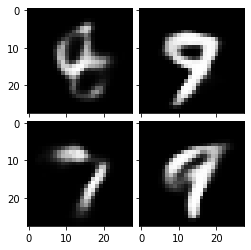

Train Epoch: 9 [0/60000 (0%)]	Loss: 107.809410
====> Epoch: 9 Average loss: 106.5273
====> Test set loss: 105.7847


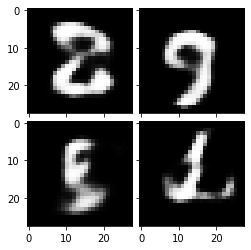

Train Epoch: 10 [0/60000 (0%)]	Loss: 111.874252
====> Epoch: 10 Average loss: 106.0927
====> Test set loss: 105.7465


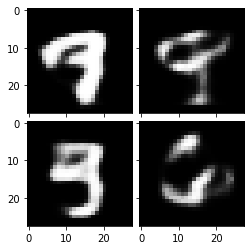

In [41]:

torch.manual_seed(args.seed)

device = torch.device("cuda" if args.cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True, **kwargs)






for epoch in range(1, args.epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(4, 20).to(device)
            sample = model.decode(sample).cpu()
            #import pdb;pdb.set_trace()
            sampled_imgs = sample.view(4, 28, 28).numpy()
            imgs = [np.array(sampled_imgs[i,:,:]) for i in range(4)]
            fig = plt.figure(figsize=(4., 4.))
            grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
            for ax, im in zip(grid, imgs):
              # Iterating over the grid returns the Axes.
              ax.imshow(im,cmap = plt.cm.gray)

            plt.show() 
            

In [ ]:
n